In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_#
from matplotlib import pyplot as plt
import time

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count
from torch.distributions import Categorical
main_seed = 0

In [3]:
env = gym.make("CartPole-v0")
env.seed(0)
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [4]:
class linearApproximator_FCDAP(nn.Module):
    def __init__(self,state_shape,outputs,hidden_dims=(32,32)):
        super(linearApproximator_FCDAP, self).__init__()
        self.input_size = state_shape
        self.out = outputs
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(\
                                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],self.out)
        self.to(self.device)
        
        
        
    def forward(self, state_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32)
        state_shape = state_shape.to(self.device)
            
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        logits = self.output_layer(x)#logits, preferences of actions
        return logits
        
    def full_pass(self, state):
        logits = self.forward(state).cpu()
        distribution = Categorical(logits=logits)
        action = distribution.sample()#sample action
        log_prob_action = distribution.log_prob(action).unsqueeze(-1)#gets prob of sampled action
        entropy = distribution.entropy().unsqueeze(-1)
        return action.item(), log_prob_action, entropy, logits

In [5]:
class linearApproximator_FCV(nn.Module):
    def __init__(self,state_shape,outputs,hidden_dims=(32,32)):
        super(linearApproximator_FCV, self).__init__()
        self.input_size = state_shape
        self.out = outputs
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(\
                                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],self.out)
        self.to(self.device)
        
        
        
    def forward(self, state_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32)
        state_shape = state_shape.to(self.device)
            
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        state_value = self.output_layer(x)#logits, preferences of actions
        return state_value

In [6]:
def worker(env,main_seed,worker_rank,\
          global_policy_network,global_value_network
          ):
    
    local_worker_seed = main_seed + worker_rank
    #set seeds
    env.seed(local_worker_seed)
    torch.manual_seed(local_worker_seed)
    np.random.seed(local_worker_seed)
    random.seed(local_worker_seed)
    
    observation_space = len(env.reset())
    action_space = env.action_space.n
    
    worker_policy_network = linearApproximator_FCDAP(observation_space,\
                                     action_space,hidden_dims=(128,64))
    worker_value_network = linearApproximator_FCV(observation_space,\
                                     1,hidden_dims=(256,128))
    
    #load state dict and policy dict from global network to worker
    worker_policy_network.load_state_dict(global_policy_network.state_dict())
    worker_value_network.load_state_dict(global_value_network.state_dict())
    
    return worker_policy_network, worker_value_network, env
    

In [7]:
def select_action(action_model, state):
    action, log_prob_action, entropy, logits = action_model.full_pass(state)
    return action, log_prob_action, entropy

In [8]:
def optimize_model(reward_store, log_pa, states,entropies,\
                   local_value_network,local_policy_network,\
                   global_policy_optimizer, global_value_optimizer,\
                   global_policy_network, global_value_network,\
                   gamma,entropy_beta):
    
    Trajectory_length = len(reward_store)
   
    
    discounts = np.logspace(0,Trajectory_length,\
                           num=Trajectory_length,base=gamma,\
                           endpoint=False)
    
    returns = np.array([np.sum(discounts[:Trajectory_length-t] * reward_store[t:]) for t in range(Trajectory_length)])
    returns = torch.tensor(returns).unsqueeze(1)

    
    states = torch.tensor(states).float()
    state_values = local_value_network(states)   
    model_state_error = returns - state_values
    model_state_loss = model_state_error.pow(2).mul(0.5).mean()
    global_value_optimizer.zero_grad()
    model_state_loss.backward()
    
    for local_params, global_params in zip(local_value_network.parameters(),\
                                          global_value_network.parameters()):
        if global_params.grad is None:
            global_params._grad = local_params.grad

    global_value_optimizer.step()
    local_value_network.load_state_dict(global_value_network.state_dict())
    
    log_pa = torch.stack(log_pa)
    
    discounts_tensor = torch.tensor(discounts).unsqueeze(1)
    advantage = returns - state_values.detach()
    local_policy_loss = -(advantage*log_pa*discounts_tensor).mean()
    entropy = torch.tensor(entropies).unsqueeze(1)
    entropy = -entropy.mean()
    local_policy_loss +=entropy_beta*entropy
    
    global_policy_optimizer.zero_grad()
    local_policy_loss.backward()
    
    #before backward pass of global param, we copy gradients
    for local_param, global_param in zip(local_policy_network.parameters(),\
                                  global_policy_network.parameters()):
        if global_param.grad is None:
            global_param._grad = local_param.grad
    
    global_policy_optimizer.step()
    
    local_policy_network.load_state_dict(global_policy_network.state_dict())

In [9]:
def train_worker(env,\
                 local_policy_network, local_value_network,\
                 global_policy_network, global_value_network,\
                 global_policy_optimizer, global_value_optimizer,\
                 max_steps, entropy_beta, gamma):
    abort_after = 60*2 #abort after 30 sec
    start = time.time()
    terminate_worker = False
    ovr_rewards = []
    while not terminate_worker:
        delta = time.time() - start
        state = env.reset()
        acc_rewards = 0
        
        n_steps = 0
        reward_store = []
        state_store = []
        log_pa = [] 
        entropy_store = []
        
        for step in count(start=1):
            action, log_prob_action, entropy = select_action(local_policy_network, state)
            next_state, reward, done, info= env.step(action)
            acc_rewards+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            
            reward_store.append(reward)
            state_store.append(state)
            log_pa.append(log_prob_action)
            entropy_store.append(entropy)
            
            state = next_state
            
            if done == True or step - n_steps == max_steps:
                #n_steps return remember...
                if is_failure:#set reward to zero if final state is an actual termination 
                    #print(reward, step - n_steps,max_steps,done )
                    reward_store[-1] = 0.0
                
                optimize_model(reward_store, log_pa, state_store,entropy_store,\
                    local_value_network,local_policy_network,\
                    global_policy_optimizer,global_value_optimizer,\
                    global_policy_network, global_value_network,\
                    gamma,entropy_beta)
                
                
                reward_store = []
                state_store = []
                log_pa = [] 
                entropy_store = []
                n_steps = step
            if done == True:
                ovr_rewards.append(acc_rewards)
                break
            #print(step - n_steps)
            if step - n_steps == max_steps or delta >= abort_after:
                #print("terminate_worker: ", terminate_worker)
                terminate_worker = True
                break
    return ovr_rewards

In [10]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        super(SharedAdam, self).__init__(
            params, lr=lr, betas=betas, eps=eps, 
            weight_decay=weight_decay, amsgrad=amsgrad)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['shared_step'] = torch.zeros(1).share_memory_()
                state['exp_avg'] = torch.zeros_like(p.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()
                if weight_decay:
                    state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
                if amsgrad:
                    state['max_exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['steps'] = self.state[p]['shared_step'].item()
                self.state[p]['shared_step'] += 1
        super().step(closure)

In [11]:
def A3C_(env, lr=0.0007, max_steps=100, entropy_beta=0.001, gamma = 0.99 ):
    main_seed = 0
    observation_space = len(env.reset())
    action_space = env.action_space.n

    global_policy_model = linearApproximator_FCDAP(observation_space,\
                                     action_space,hidden_dims=(128,64))
    
    global_value_model = linearApproximator_FCV(observation_space,\
                                     1,hidden_dims=(256,128))
    
    global_policy_optimizer = SharedAdam(global_policy_model.parameters(),lr=lr)
    global_value_optimizer = SharedAdam(global_value_model.parameters(),lr=lr)
    
    worker_reward = []
    for worker_rank in tqdm(range(10)):
        worker_policy_model, worker_value_model, worker_env = worker(env,main_seed,worker_rank,\
                                                              global_policy_model,global_value_model)
        
        rwd = train_worker(worker_env,\
                 worker_policy_model, worker_value_model,\
                 global_policy_model, global_value_model,\
                 global_policy_optimizer, global_value_optimizer,\
                 max_steps, entropy_beta, gamma)
        worker_reward.append(rwd)
    return worker_reward

In [12]:
r = A3C_(env)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:00<00:00, 120.06s/it]


In [13]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(r[9], size=10)

In [14]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

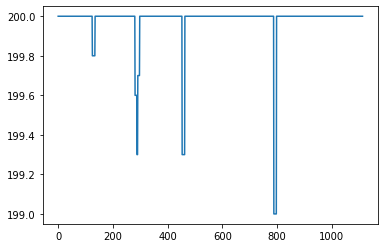

In [15]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size